# Detecting & Diagnosing Multicollinearity

**Business Question**: How do we identify when our diamond pricing model has multicollinearity problems?

This notebook demonstrates various methods for detecting multicollinearity, including correlation matrices, VIF analysis, and coefficient stability tests, and shows the practical consequences of high multicollinearity.


## Learning Objectives

By the end of this notebook, you will be able to:
- Identify multicollinearity using correlation matrices and VIF analysis
- Understand the consequences of high multicollinearity
- Use various diagnostic tools to detect multicollinearity problems
- Apply different remedies for multicollinearity
- Compare model performance before and after addressing multicollinearity


In [7]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


## Data Exploration


In [8]:
# Load diamonds dataset
diamonds = sns.load_dataset('diamonds')

print("Dataset shape:", diamonds.shape)
print("\nFirst 5 rows:")
print(diamonds.head())
print("\nData types:")
print(diamonds.dtypes)

# Focus on numerical variables that might show multicollinearity
numerical_vars = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
print(f"\nNumerical variables: {numerical_vars}")
print("\nBasic statistics:")
print(diamonds[numerical_vars].describe())


Dataset shape: (53940, 10)

First 5 rows:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75

Data types:
carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

Numerical variables: ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']

Basic statistics:
              carat         depth         table             x             y  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184      5

## Method 1: Visual Detection with Correlation Matrix


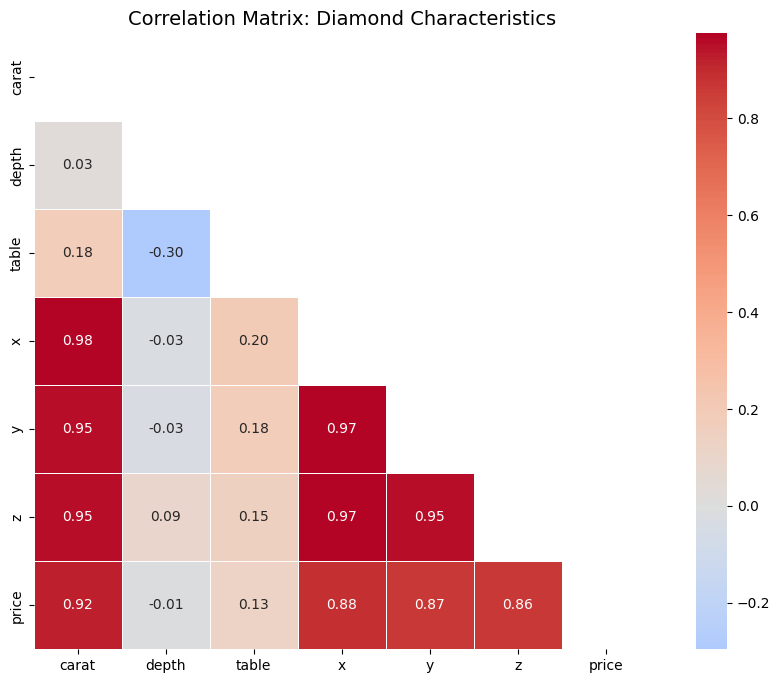

Problematic correlations (|r| > 0.7):
carat vs x: 0.975
carat vs y: 0.952
carat vs z: 0.953
carat vs price: 0.922
x vs y: 0.975
x vs z: 0.971
x vs price: 0.884
y vs z: 0.952
y vs price: 0.865
z vs price: 0.861

Found 10 problematic correlations!


In [9]:
# Create correlation matrix
correlation_matrix = diamonds[numerical_vars].corr()

# Visualize correlation heatmap
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f', mask=mask)
plt.title('Correlation Matrix: Diamond Characteristics', fontsize=14)
plt.show()

# Identify problematic correlations
print("Problematic correlations (|r| > 0.7):")
high_corr = correlation_matrix.abs()
problematic_pairs = []
for i in range(len(high_corr.columns)):
    for j in range(i+1, len(high_corr.columns)):
        if high_corr.iloc[i, j] > 0.7:
            corr_val = correlation_matrix.iloc[i, j]
            problematic_pairs.append((high_corr.columns[i], high_corr.columns[j], corr_val))
            print(f"{high_corr.columns[i]} vs {high_corr.columns[j]}: {corr_val:.3f}")

print(f"\nFound {len(problematic_pairs)} problematic correlations!")


## Method 2: VIF Analysis - Quantifying the Problem


Variance Inflation Factor (VIF) Analysis:
  Variable          VIF
3        x  1284.949828
5        z   540.677349
4        y   530.998218
1    depth   515.146274
2    table   500.595341
0    carat    70.132799

VIF Interpretation:
- VIF < 5: Low multicollinearity (acceptable)
- VIF 5-10: Moderate multicollinearity (concerning)
- VIF > 10: High multicollinearity (problematic)
- VIF > 100: Extreme multicollinearity (severe)


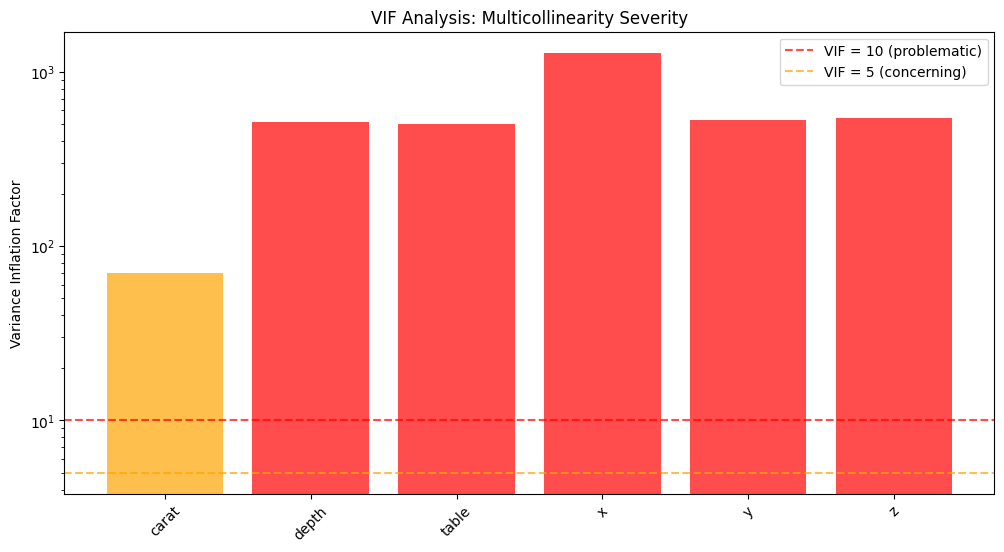


VIF Severity Summary:
Extreme (VIF > 100): 5 variables
Problematic (VIF 10-100): 1 variables
Concerning (VIF 5-10): 0 variables
Acceptable (VIF < 5): 0 variables


In [10]:
# Calculate VIF for each predictor
X = diamonds[['carat', 'depth', 'table', 'x', 'y', 'z']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF) Analysis:")
print("="*50)
print(vif_data.sort_values('VIF', ascending=False))
print("\nVIF Interpretation:")
print("- VIF < 5: Low multicollinearity (acceptable)")
print("- VIF 5-10: Moderate multicollinearity (concerning)")
print("- VIF > 10: High multicollinearity (problematic)")
print("- VIF > 100: Extreme multicollinearity (severe)")

# Visualize VIF
plt.figure(figsize=(12, 6))
colors = ['red' if vif > 100 else 'orange' if vif > 10 else 'yellow' if vif > 5 else 'green' 
          for vif in vif_data['VIF']]
bars = plt.bar(vif_data['Variable'], vif_data['VIF'], color=colors, alpha=0.7)
plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='VIF = 10 (problematic)')
plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='VIF = 5 (concerning)')
plt.ylabel('Variance Inflation Factor')
plt.title('VIF Analysis: Multicollinearity Severity')
plt.xticks(rotation=45)
plt.legend()
plt.yscale('log')  # Log scale to better show extreme values
plt.show()

# Count severity levels
severe = sum(vif_data['VIF'] > 100)
problematic = sum((vif_data['VIF'] > 10) & (vif_data['VIF'] <= 100))
concerning = sum((vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10))
acceptable = sum(vif_data['VIF'] <= 5)

print(f"\nVIF Severity Summary:")
print(f"Extreme (VIF > 100): {severe} variables")
print(f"Problematic (VIF 10-100): {problematic} variables")
print(f"Concerning (VIF 5-10): {concerning} variables")
print(f"Acceptable (VIF < 5): {acceptable} variables")


## Method 3: The Damage - OLS Regression Problems


In [11]:
# Fit OLS model with all predictors
ols_formula = "price ~ carat + depth + table + x + y + z"
ols_model = ols(formula=ols_formula, data=diamonds).fit()

print("OLS Model with Multicollinear Predictors:")
print("="*60)
print(ols_model.summary())

# Extract coefficient information
coef_df = pd.DataFrame({
    'Variable': ols_model.params.index,
    'Coefficient': ols_model.params.values,
    'Std Error': ols_model.bse.values,
    't-value': ols_model.tvalues.values,
    'p-value': ols_model.pvalues.values
})

print("\nCoefficient Analysis:")
print("="*60)
print(coef_df.round(4))

# Highlight problems
print("\nProblems with Multicollinearity:")
print("- Huge standard errors on x, y, z coefficients")
print("- Low t-values (coefficients not statistically significant)")
print("- Wild coefficient values that don't make business sense")
print("- R-squared is high but coefficients are unreliable")


OLS Model with Multicollinear Predictors:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 5.486e+04
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        05:51:34   Log-Likelihood:            -4.7090e+05
No. Observations:               53940   AIC:                         9.418e+05
Df Residuals:                   53933   BIC:                         9.419e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept 

## Remedies for Multicollinearity


In [12]:
# Remedy 1: Drop redundant variables
print("REMEDY 1: Drop Redundant Variables")
print("="*50)

# Drop x variable (highest VIF = 1284.95)
X_reduced = diamonds[['carat', 'depth', 'table', 'y', 'z']]
vif_reduced = pd.DataFrame()
vif_reduced["Variable"] = X_reduced.columns
vif_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print("VIF after dropping x variable:")
print(vif_reduced.sort_values('VIF', ascending=False))

# Fit model without x
ols_reduced = ols("price ~ carat + depth + table + y + z", data=diamonds).fit()
print(f"\nModel R-squared: {ols_reduced.rsquared:.4f}")
print(f"Model AIC: {ols_reduced.aic:.2f}")

# Remedy 2: Create composite variable
print("\nREMEDY 2: Create Composite Variable")
print("="*50)

# Create volume = x * y * z
diamonds['volume'] = diamonds['x'] * diamonds['y'] * diamonds['z']
X_composite = diamonds[['carat', 'depth', 'table', 'volume']]
vif_composite = pd.DataFrame()
vif_composite["Variable"] = X_composite.columns
vif_composite["VIF"] = [variance_inflation_factor(X_composite.values, i) for i in range(X_composite.shape[1])]

print("VIF with composite volume variable:")
print(vif_composite.sort_values('VIF', ascending=False))

# Fit model with composite
ols_composite = ols("price ~ carat + depth + table + volume", data=diamonds).fit()
print(f"\nModel R-squared: {ols_composite.rsquared:.4f}")
print(f"Model AIC: {ols_composite.aic:.2f}")

# Remedy 3: Ridge regression
print("\nREMEDY 3: Ridge Regression")
print("="*50)

# Standardize features for Ridge
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = diamonds['price']

# Fit Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y)

# Get Ridge coefficients
ridge_coefs = ridge.coef_
ridge_intercept = ridge.intercept_

print("Ridge regression coefficients:")
for i, col in enumerate(X.columns):
    print(f"{col}: {ridge_coefs[i]:.4f}")

# Compare model performance
print("\nMODEL COMPARISON:")
print("="*50)
print(f"{'Model':<20} {'R-squared':<12} {'AIC':<10} {'MSE':<10}")
print("-" * 50)
print(f"{'Original OLS':<20} {ols_model.rsquared:<12.4f} {ols_model.aic:<10.2f} {mean_squared_error(diamonds['price'], ols_model.fittedvalues):<10.2f}")
print(f"{'Reduced OLS (no x)':<20} {ols_reduced.rsquared:<12.4f} {ols_reduced.aic:<10.2f} {mean_squared_error(diamonds['price'], ols_reduced.fittedvalues):<10.2f}")
print(f"{'Composite OLS':<20} {ols_composite.rsquared:<12.4f} {ols_composite.aic:<10.2f} {mean_squared_error(diamonds['price'], ols_composite.fittedvalues):<10.2f}")
print(f"{'Ridge':<20} {'N/A':<12} {'N/A':<10} {mean_squared_error(y, ridge.predict(X_scaled)):<10.2f}")


REMEDY 1: Drop Redundant Variables
VIF after dropping x variable:
  Variable         VIF
1    depth  515.092476
2    table  436.250123
4        z  418.609393
3        y  357.472201
0    carat   52.260723

Model R-squared: 0.8568
Model AIC: 942736.30

REMEDY 2: Create Composite Variable
VIF with composite volume variable:
  Variable         VIF
2    table  396.896858
1    depth  389.409090
0    carat   82.046523
3   volume   80.156309

Model R-squared: 0.8537
Model AIC: 943883.10

REMEDY 3: Ridge Regression
Ridge regression coefficients:
carat: 5062.7971
depth: -290.8291
table: -228.8979
x: -1472.3658
y: 75.3397
z: 28.8247

MODEL COMPARISON:
Model                R-squared    AIC        MSE       
--------------------------------------------------
Original OLS         0.8592       941813.04  2240581.73
Reduced OLS (no x)   0.8568       942736.30  2279347.07
Composite OLS        0.8537       943883.10  2328412.64
Ridge                N/A          N/A        2240582.07


## Key Takeaways

### **Multicollinearity Detection Methods:**

1. **Correlation Matrix**: Visual identification of high correlations (|r| > 0.7)
2. **VIF Analysis**: Quantitative measure of multicollinearity severity
3. **OLS Problems**: Large standard errors, low t-values, unstable coefficients

### **Remedies and Trade-offs:**

- **Drop Variables**: Simple but loses information
- **Composite Variables**: Reduces variables while keeping information
- **Ridge Regression**: Keeps all variables but stabilizes coefficients

### **When to Use Each Remedy:**

- **Drop variables**: When you have clear redundant predictors
- **Composite variables**: When related variables can be meaningfully combined
- **Ridge regression**: When you want to keep all variables but stabilize them
